In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import warnings
from tqdm import tqdm
from scipy.optimize import curve_fit

import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from astropy.io import fits
import astropy.units as u
import astropy.constants as const
import astropy.coordinates as coord
from astropy.table import Table, vstack, hstack, join
from astropy.modeling import models
from specutils.fitting import find_lines_threshold, find_lines_derivative, fit_lines
from specutils.manipulation import noise_region_uncertainty
from specutils import Spectrum1D, SpectralRegion
from astropy.nddata import NDUncertainty

from astroquery.simbad import Simbad
from astroquery.nist import Nist
from astroquery.xmatch import XMatch
from astroquery.vizier import Vizier
from astroquery.mast import Observations

%matplotlib inline

Could not import regions, which is required for some of the functionalities of this module.


In [19]:
def redshift_correction(wavelengths_observed, z):
    '''
    Finds amount by which stellar emission is redshifted, and subtract this from stellar spectrum.
    Input:
    wavelengths_observed: observed wavelengths of spectrum (Angstroms)
    z: redshift of star
    
    Returns:
    wavelengths_emitted: emitted wavelengths of spectrum (Angstroms)
    '''
    
    wavelengths_emitted = wavelengths_observed / (1 + z)
    return wavelengths_emitted


def blackbody(wavelengths, Teff):
    '''
    Returns blackbody continuum for an object at Teff (K)
    Inputs:
    wavelengths [arr]: (Angstroms)
    Teff [scalar]: effective temperature (K)
    
    Returns:
    B [arr]: blackbody continuum for Teff (unitless)
    '''
    
    wav = wavelengths * aangstrom2meter * u.m
    Teff = Teff * u.K
    
    B = (2. * const.h * const.c**2) / (wav**5.) / ( np.exp( (const.h * const.c) / (wav * const.k_B * Teff) ) - 1. )
    
    return B / B.max()


def fitBB(wavelengths, Teff, a, b):
    '''
    Scale blackbody continuum emission.
    Input:
    wavelengths [arr]: spectrum wavelengths (Angstroms)
    Teff [scalar]: effective temperature of star (K)
    a, b: scaling factors to be optimized by curve_fit
    
    Returns:
    -- [arr]: blackbody continuum curve
    '''
    return a * blackbody(wavelengths, Teff) + b

In [17]:
starname = 'HD  58805' ## photometric calibration star

table = Table.read('/Users/isabelkain/Desktop/GALEX/data/dataset.ecsv')

table[table['main_id']==starname] ## FIXME Table has double spaces in some parts, that's why it doesnt recognize
# table[5]

main_id,main_type,sp_type,s_ra,s_dec,RAJ2000,DEJ2000,ra,dec,t_min,t_max,t_exptime,obs_title,jpegURL,dataURL,RAfdeg,DEfdeg,FUVexp,NUVexp,FUVmag,e_FUVmag,NUVmag,e_NUVmag,Fafl,Nafl,Fexf,Nexf,Fflux,e_Fflux,Nflux,e_Nflux,coo_qual,coo_bibcode,other_types,radvel,radvel_err,redshift,redshift_err,plx,plx_err,pmra,pmdec,B,V,R,J,H,K,u,g,r,i,z,FLUX_B,FLUX_ERROR_V,FLUX_SYSTEM_V,FLUX_QUAL_V,FLUX_R,FLUX_ERROR_R,FLUX_SYSTEM_R,FLUX_QUAL_R,FLUX_I,FLUX_ERROR_I,FLUX_SYSTEM_I,FLUX_QUAL_I,FLUX_J,FLUX_ERROR_J,FLUX_SYSTEM_J,FLUX_QUAL_J,FLUX_K,FLUX_ERROR_K,FLUX_SYSTEM_K,FLUX_QUAL_K,TYPED_ID,Fe_H_Teff,Fe_H_log_g,Fe_H_Fe_H,Fe_H_flag,ROT_upVsini,ROT_Vsini,ROT_err,ROT_mes,ROT_qual,SP_TYPE,SP_QUAL,OTYPE,V__vartyp,V__LoVmax,V__Vmax,V__R_Vmax,V__magtyp,V__UpVmin,V__Vmin,V__R_Vmin,V__UpPeriod,V__period,V__R_period,V__epoch,PLX_VALUE,PLX_PREC,PLX_ERROR,PLX_QUAL,Distance_distance,Distance_unit,Distance_merr,Distance_perr,Distance_method
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,,,,mag,,,,mag,,,,mag,,,,mag,,,,,unit-degK,cm / s2,,,,km / s,,,,,,,,,mag,,,,mag,,,d,,d,mas,,mas,,,,,,
str23,str19,str18,float64,float64,float64,float64,float64,float64,float64,float64,float64,str114,str74,str64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,str1,str19,str33,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,object,str1,float32,float32,object,str1,float32,float32,object,str1,float32,float32,object,str1,float32,float32,object,str1,object,int32,float32,float32,str1,str1,float32,float32,int32,str1,object,str1,object,str4,str1,float32,str1,str1,str1,float32,str1,str1,float64,str1,float64,float64,int16,float32,str1,float64,str2,float64,float64,str5
HD 58805,Star,F5.5VFe-1.0CH-0.6,101.74551466079998,-87.0249004777,101.763845,-87.02573,101.7440655096,-87.024963508,47184.71825,47184.71827,1.508,Photometric Calibration Stars,http://archive.stsci.edu/browse/previews/iue/mx/swp/32000/gif/swp32770.gif,http://archive.stsci.edu/pub/vospectra/iue2/swp32770mxlo_vo.fits,94.085397,-86.719459,99.1,99.1,--,--,12.2293,0.0035,0,17,0,0,--,--,46588.5,148.05099,A,2020yCat.1350....0G,*|IR|UV,4.2,0.19,1.4e-05,6e-07,25.8076,0.0161,4.955,4.377,6.873,6.462,--,5.625,5.423,5.325,--,--,--,--,--,6.873,0.010,Vega,D,--,--,,--,--,--,,--,5.625,0.026,Vega,C,5.325,0.023,Vega,C,HD 58805,6556,4.2300,--,--,--,--,--,0,--,F5.5VFe-1.0CH-0.6,C,Star,--,--,--,--,--,--,--,--,--,--,--,--,25.808,4,0.0161,A,38.7480,pc,-0.0242,0.0242,paral


In [20]:
## Open FITS file

hdul = fits.open('/Users/isabelkain/Desktop/GALEX/data/swp32770mxlo_vo.fits')


## Collect exposure information from header

target = hdul[1].header['OBJECT']       # target name
spclass = hdul[1].header['SRCCLASS']    # Object Class 
camera = hdul[0].header['CAMERA']       # or hdul[1].header['INSTRUME']
dispersion = hdul[0].header['DISPERSN'] # LOW or HIGH
fluxcal = hdul[1].header['FLUX_CAL']    # should be ABSOLUTE
tstart = hdul[0].header['*JD-OBS']      # [d] MJD exposure start time 
exptime = hdul[1].header['EXPOSURE']    # [s] eff. exposure duration
snr = hdul[1].header['DER_SNR']         # Derived signal-to-noise ratio  


## Collect star information from dataset

z = table[table['main_id']==starname]['redshift'].value[0]
Teff = table[table['main_id']==starname]['Fe_H_Teff'].value[0]


## Read in wavelength, flux, and fluxerr data

wavelengths = redshift_correction(hdul[1].data['WAVE'][0], z)
rawflux = hdul[1].data['FLUX'][0] # raw because blackbody continuum will soon be subtracted
fluxerr = hdul[1].data['SIGMA'][0]

print(target)
print(spclass)
print(camera)
print(dispersion)
print(fluxcal)
print(tstart)
print(exptime)
print(snr)

WAVECAL
WAVELENGTH CALIBRATION LAMP
SWP
LOW
ABSOLUTE
SJD-OBS =        2447184.71825 / Julian Date start of obs.                      END                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

Text(0.5, 1.0, 'LOW-DISP SWP, SNR 4.37')

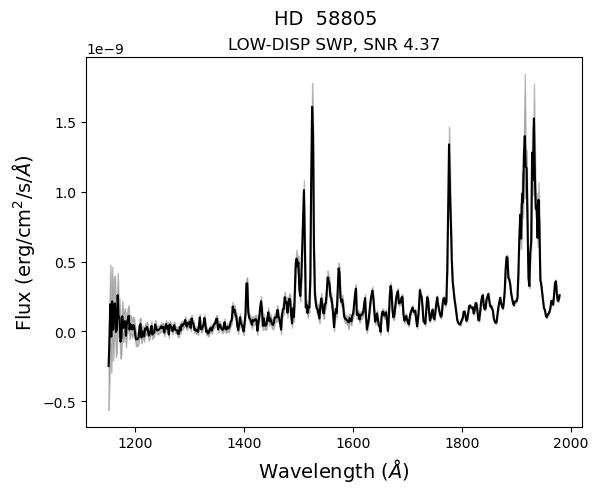

In [24]:
## Visualize spectrum

# fig, ax = plt.subplots(1,2, figsize=(10,5))
plt.tight_layout(rect=[0, 0.03, 1, 0.90])

plt.plot( wavelengths, rawflux, c='k')
plt.fill_between(wavelengths, rawflux + fluxerr, rawflux - fluxerr, alpha=0.5, color='gray')

# ax[1].plot( wavelengths, rawflux, c='k')
# ax[1].fill_between(wavelengths, rawflux + fluxerr, rawflux - fluxerr, alpha=0.5, color='gray')
# ax[1].set_ylim(-10**-14, 10**-13)

plt.xlabel(r'Wavelength ($\AA$)', fontsize=14)
plt.ylabel(r'Flux (erg/cm$^2$/s/$\AA$)', fontsize=14)

plt.suptitle(f'{starname}', fontsize=14)
plt.title(f'{dispersion}-DISP {camera}, SNR {snr}')

# plt.ylim(-.2*10**-9, 10**-9)
# plt.yscale('log')